# FFT Magnitude Visualization (Zoomed, Simple/Complex)
Choose between the simple signal or the complex mixed signal below. Plots use larger fonts and zoom controls for clarity.

Signal: complex
Files: data_2sin20t+sin16t-cos35t-3sin(5t-25deg).txt | fft_data_2sin20t+sin16t-cos35t-3sin(5t-25deg).txt
N_FFT = 32768 | dt = 0.0012566621946798109
Half-spectrum max magnitude: 23738.697265625


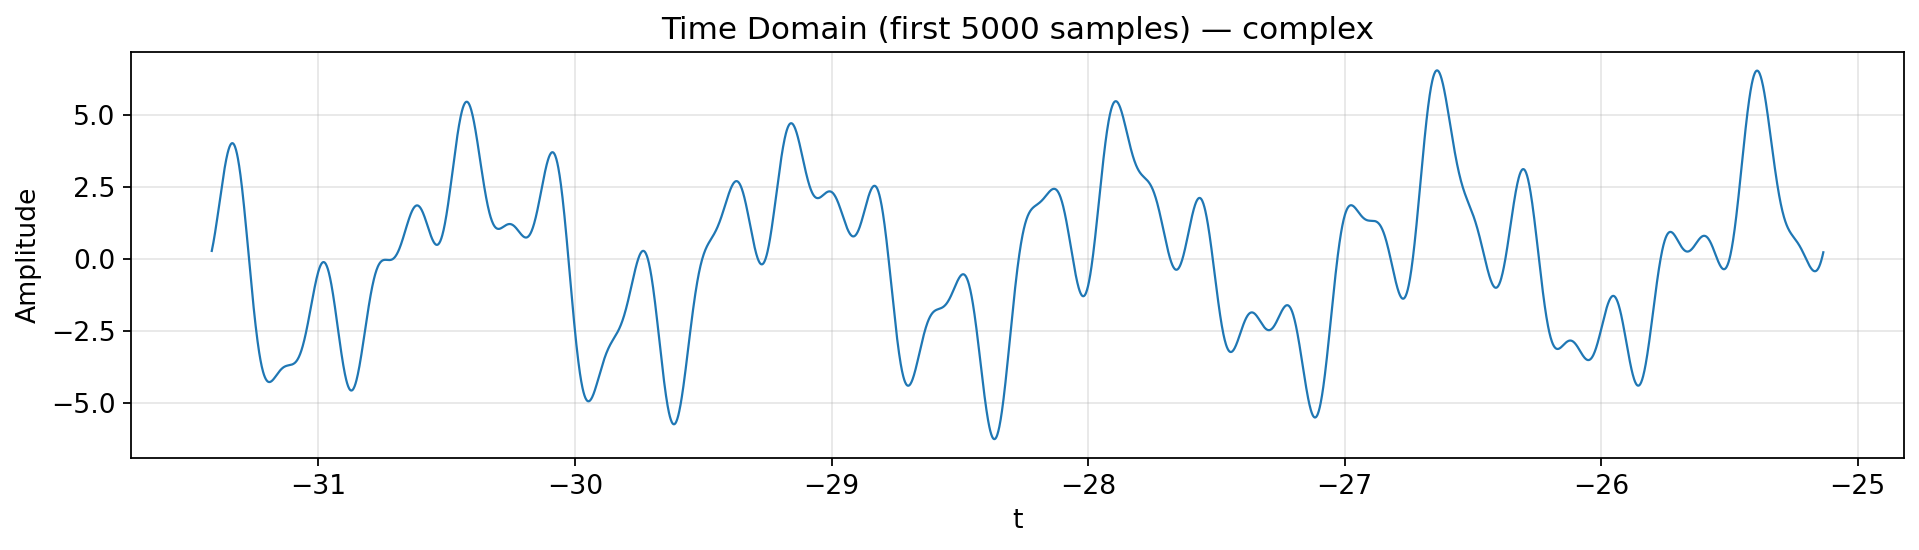

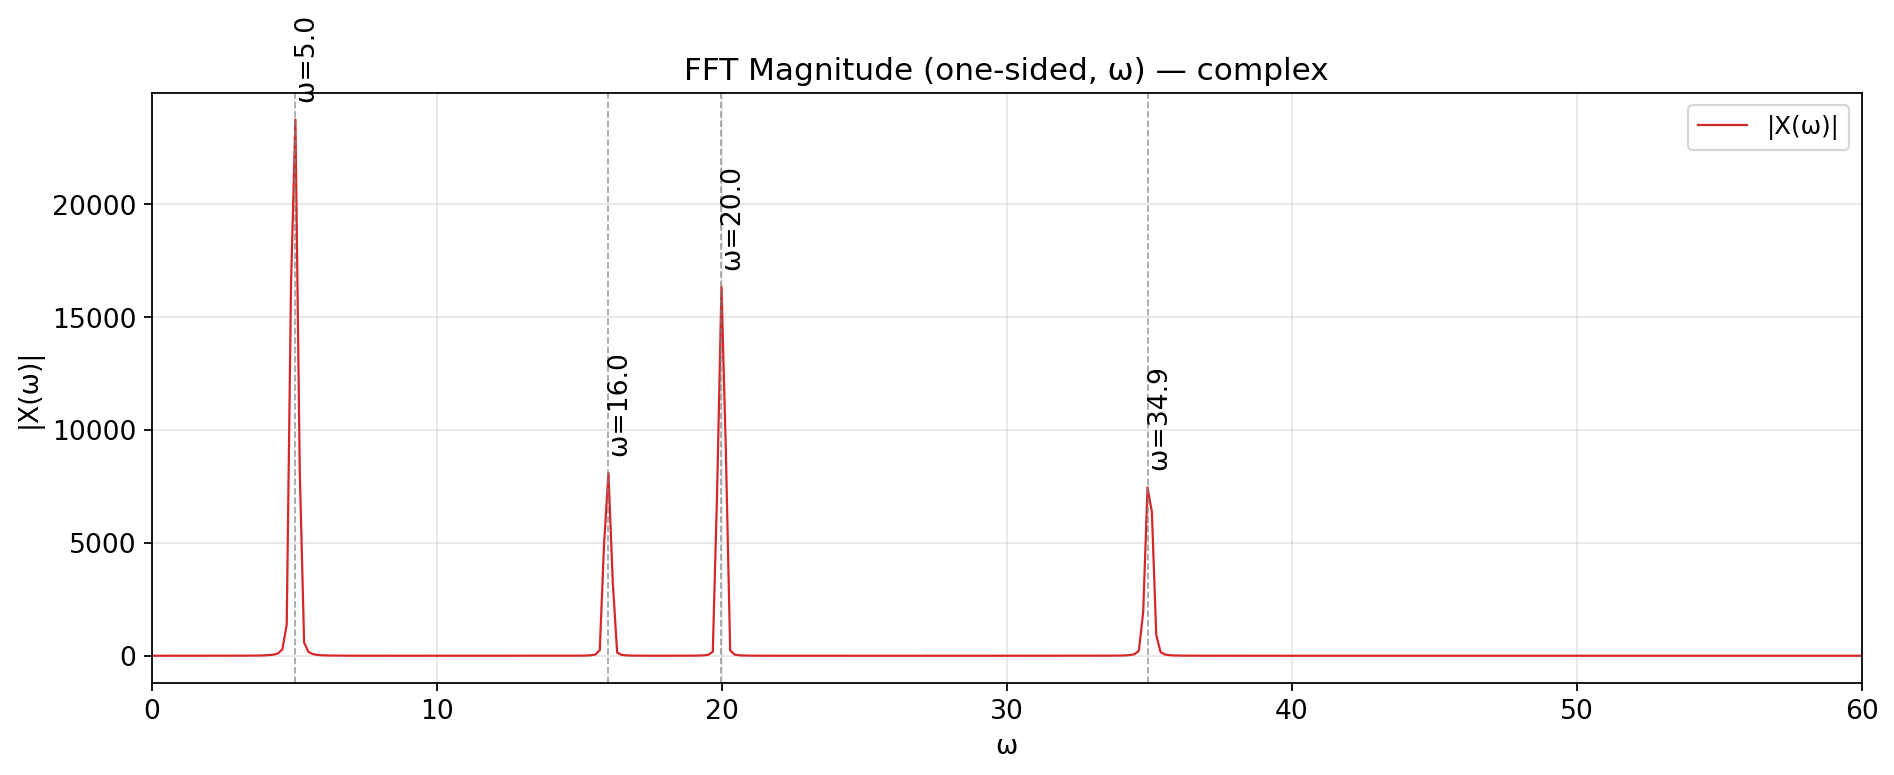

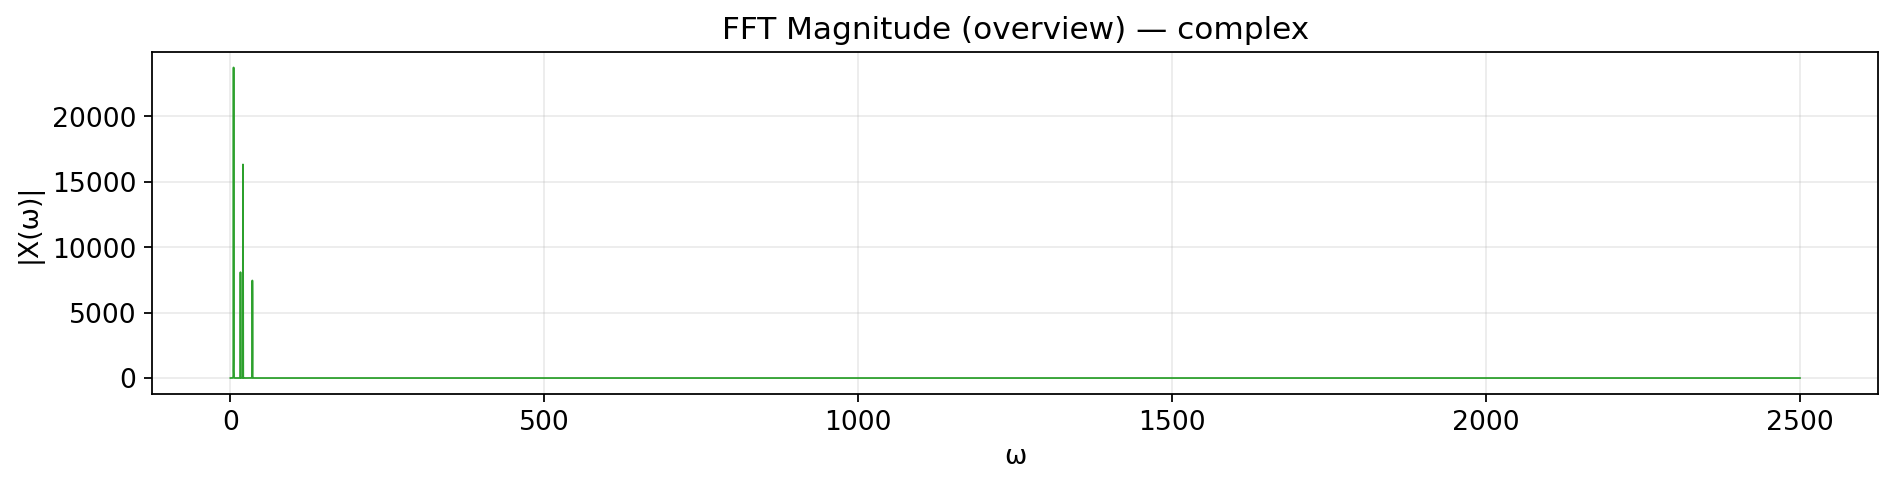

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from pathlib import Path

# Readability
plt.rcParams['figure.dpi'] = 160
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 11

# Project sampling defaults (match dataframe.h)
DF_SIZE = 50000
DF_START = -10.0 * math.pi
DF_END   =  10.0 * math.pi
DT = (DF_END - DF_START) / (DF_SIZE - 1)

# FFT length used by C (power-of-two ≤ DF_SIZE)
def pow2_leq(n: int) -> int:
    p = 1
    while (p << 1) <= n:
        p <<= 1
    return p

N_FFT = pow2_leq(DF_SIZE)  # 32768 for DF_SIZE=50000

# Select signal: 'simple' or 'complex'
signals = {
    'simple':  ('data_2sin20t.txt', 'fft_data_2sin20t.txt', (0.0, 30.0)),
    'complex': ('data_2sin20t+sin16t-cos35t-3sin(5t-25deg).txt',
                'fft_data_2sin20t+sin16t-cos35t-3sin(5t-25deg).txt', (0.0, 60.0)),
}
signal_name = 'complex'  # <- change to 'simple' to view the simple waveform
time_file_name, fft_file_name, default_xlim = signals[signal_name]
time_file = Path(time_file_name)
fft_mag_file = Path(fft_file_name)

# Zoom/plot controls (can override defaults)
n_show_time = 5000
freq_xlim_omega = default_xlim
use_log_mag = False
annotate_peaks = True
top_k_peaks = 8
peak_rel_height = 0.05

# Load files
y_time = np.loadtxt(time_file, dtype=np.float32)
y_mag  = np.loadtxt(fft_mag_file, dtype=np.float32)

assert y_time.size == DF_SIZE, f'Expected {DF_SIZE} samples, got {y_time.size}'
assert y_mag.size  == DF_SIZE, f'Expected {DF_SIZE} samples, got {y_mag.size}'

# Recreate time axis
t = np.linspace(DF_START, DF_END, DF_SIZE, dtype=np.float64)

# Frequency axes
f = np.arange(N_FFT, dtype=np.float64) / (N_FFT * DT)
omega = 2.0 * math.pi * f

# One-sided spectrum
k_half = N_FFT // 2
omega_half = omega[:k_half]
mag_half = y_mag[:k_half].astype(np.float64)

print('Signal:', signal_name)
print('Files:', time_file_name, '|', fft_file_name)
print('N_FFT =', N_FFT, '| dt =', DT)
print('Half-spectrum max magnitude:', float(np.max(mag_half)))

# Time-domain plot
plt.figure(figsize=(12, 3.6))
plt.plot(t[:n_show_time], y_time[:n_show_time], lw=1.0, color='tab:blue')
plt.title(f'Time Domain (first {n_show_time} samples) — {signal_name}')
plt.xlabel('t')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Magnitude spectrum (ω)
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(omega_half, mag_half, lw=1.0, color='tab:red', label='|X(ω)|')
ax.set_title(f'FFT Magnitude (one-sided, ω) — {signal_name}')
ax.set_xlabel('ω')
ax.set_ylabel('|X(ω)|')
ax.set_xlim(*freq_xlim_omega)
if use_log_mag:
    ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Peak detection
if annotate_peaks:
    thr = peak_rel_height * float(np.max(mag_half))
    local_max = (mag_half[1:-1] > mag_half[:-2]) & (mag_half[1:-1] > mag_half[2:]) & (mag_half[1:-1] >= thr)
    peak_idx = np.nonzero(local_max)[0] + 1
    if peak_idx.size > 0:
        top_idx = peak_idx[np.argsort(mag_half[peak_idx])][-top_k_peaks:]
        top_idx = np.sort(top_idx)
        for i in top_idx:
            w = omega_half[i]
            m = mag_half[i]
            ax.axvline(w, color='tab:gray', ls='--', lw=0.8, alpha=0.7)
            ax.text(w, m, f'  ω={w:.1f}', rotation=90, va='bottom', ha='left', color='black')

ax.legend()
plt.tight_layout()
plt.show()

# Overview plot
plt.figure(figsize=(12, 3.2))
plt.plot(omega_half, mag_half, lw=0.8, color='tab:green')
plt.title(f'FFT Magnitude (overview) — {signal_name}')
plt.xlabel('ω')
plt.ylabel('|X(ω)|')
plt.grid(True, alpha=0.25)
plt.tight_layout()
plt.show()


## Tips
- Switch `signal_name` between 'simple' and 'complex'.
- Adjust `freq_xlim_omega` to zoom (e.g., (0, 60) for the complex case).
- Enable `use_log_mag` to reveal smaller peaks next to large ones.
- Tweak `top_k_peaks` and `peak_rel_height` to control annotations.